In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, jaccard_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import seaborn as sns
import time

In [ ]:
class H5BrainDataset(Dataset):
    def __init__(self, file_list, image_size=128):
        self.file_list = file_list
        self.image_size = image_size

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        with h5py.File(file_path, 'r') as f:
            image = f['image'][:]  # shape: (240, 240, 4)
            mask = f['mask'][:]    # shape: (240, 240, 3)

        # -------- Convert to PyTorch tensors --------
        image = image.transpose(2, 0, 1).astype(np.float32)  # (4, H, W)
        mask = np.argmax(mask, axis=-1)                     # (H, W), class indices [0, 1, 2]

        # Resize image
        image = torch.from_numpy(image)
        image = TF.resize(image, [self.image_size, self.image_size])

        # Resize mask using NEAREST to preserve class indices
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)
        mask = torch.from_numpy(mask).long()  # required for CrossEntropyLoss

        return image, mask  # image: [4, H, W], mask: [H, W]

In [ ]:
# STEP 2: Load Dataset

data_dir = '/content/drive/MyDrive/data'
# List all .h5 files
h5_files = sorted([
    os.path.join(data_dir, f) for f in os.listdir(data_dir)
    if f.endswith('.h5')
])

# Split into training and validation sets
train_files, val_files = train_test_split(h5_files, test_size=0.3, random_state=42)

# Load datasets with resizing to 128x128 and filtering of empty masks
train_dataset = H5BrainDataset(train_files, image_size=128)
val_dataset = H5BrainDataset(val_files, image_size=128)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=1, pin_memory=True)



In [ ]:
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")


Train samples: 8684
Val samples: 3723


In [ ]:
print("Number of .h5 files:", len(h5_files))
file_path = h5_files[0]  # Or any specific file
with h5py.File(file_path, 'r') as f:
    print("Keys:", list(f.keys()))
    print("Image shape:", f['image'].shape)
    print("Mask shape:", f['mask'].shape)

Number of .h5 files: 12407
Keys: ['image', 'mask']
Image shape: (240, 240, 4)
Mask shape: (240, 240, 3)


In [ ]:
# STEP 3: Define U-Net for multi-class segmentation
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        super(UNet, self).__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        # Contracting Path :- Feature Extraction (Encoder) :
        self.enc1 = nn.Sequential(CBR(in_channels, 64), CBR(64, 64))
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Bottleneck Processing :
        self.bottleneck = nn.Sequential(CBR(128, 256), CBR(256, 256))

        # Expanding Path :- Reconstruction and Localization (Decoder):
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(CBR(256, 128), CBR(128, 64))
        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(CBR(128, 64), CBR(64, 64))

        # Output layer
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)


    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)  # No softmax here


In [ ]:
# Loss
criterion = nn.CrossEntropyLoss()

In [ ]:
# Automatically use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
  # Force CPU since CUDA is not available

Using device: cuda


In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA A100-SXM4-40GB


In [ ]:
# # # STEP 5: Train the Model

# Training setup
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, 31):
    print(f"\nEpoch {epoch}/30")

    model.train()
    running_loss = 0
    correct_pixels = 0
    total_pixels = 0

    train_loader_tqdm = tqdm(train_loader, desc="Training", unit="batch")

    for img, mask in train_loader_tqdm:
        img, mask = img.to(device), mask.to(device)

        pred = model(img)
        loss = criterion(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(pred, dim=1)
        correct_pixels += (preds == mask).sum().item()
        total_pixels += torch.numel(mask)

        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_pixels / total_pixels
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation

    model.eval()
    val_loss = 0
    correct_pixels = 0
    total_pixels = 0
    all_preds = []
    all_targets = []

    val_loader_tqdm = tqdm(val_loader, desc="Validation", unit="batch", leave=False)

    with torch.no_grad():
        for img, mask in val_loader_tqdm:
            img, mask = img.to(device), mask.to(device)

            pred = model(img)
            loss = criterion(pred, mask)
            val_loss += loss.item()

            preds = torch.argmax(pred, dim=1)
            correct_pixels += (preds == mask).sum().item()
            total_pixels += torch.numel(mask)

            all_preds.append(preds.cpu())
            all_targets.append(mask.cpu())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_pixels / total_pixels
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} || "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")



Epoch 1/30


Training: 100%|██████████| 1086/1086 [04:15<00:00,  4.24batch/s, loss=0.0525]


Train Loss: 0.2612 | Train Acc: 0.9773 || Val Loss: 0.0578 | Val Acc: 0.9959

Epoch 2/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.51batch/s, loss=0.0208]


Train Loss: 0.0330 | Train Acc: 0.9961 || Val Loss: 0.0189 | Val Acc: 0.9970

Epoch 3/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.51batch/s, loss=0.0148]


Train Loss: 0.0151 | Train Acc: 0.9968 || Val Loss: 0.0112 | Val Acc: 0.9973

Epoch 4/30


Training: 100%|██████████| 1086/1086 [01:44<00:00, 10.44batch/s, loss=0.0133]


Train Loss: 0.0102 | Train Acc: 0.9972 || Val Loss: 0.0089 | Val Acc: 0.9973

Epoch 5/30


Training: 100%|██████████| 1086/1086 [01:44<00:00, 10.41batch/s, loss=0.0102]


Train Loss: 0.0081 | Train Acc: 0.9974 || Val Loss: 0.0067 | Val Acc: 0.9978

Epoch 6/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.49batch/s, loss=0.0137]


Train Loss: 0.0068 | Train Acc: 0.9976 || Val Loss: 0.0063 | Val Acc: 0.9977

Epoch 7/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.49batch/s, loss=0.00171]


Train Loss: 0.0061 | Train Acc: 0.9978 || Val Loss: 0.0058 | Val Acc: 0.9978

Epoch 8/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.49batch/s, loss=0.00222]


Train Loss: 0.0056 | Train Acc: 0.9979 || Val Loss: 0.0053 | Val Acc: 0.9980

Epoch 9/30


Training: 100%|██████████| 1086/1086 [01:42<00:00, 10.55batch/s, loss=0.00706]


Train Loss: 0.0051 | Train Acc: 0.9980 || Val Loss: 0.0049 | Val Acc: 0.9981

Epoch 10/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.45batch/s, loss=0.00516]


Train Loss: 0.0048 | Train Acc: 0.9981 || Val Loss: 0.0047 | Val Acc: 0.9982

Epoch 11/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.52batch/s, loss=0.0103]


Train Loss: 0.0044 | Train Acc: 0.9983 || Val Loss: 0.0044 | Val Acc: 0.9983

Epoch 12/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.48batch/s, loss=0.00237]


Train Loss: 0.0042 | Train Acc: 0.9983 || Val Loss: 0.0046 | Val Acc: 0.9982

Epoch 13/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.48batch/s, loss=0.00153]


Train Loss: 0.0040 | Train Acc: 0.9984 || Val Loss: 0.0041 | Val Acc: 0.9984

Epoch 14/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.48batch/s, loss=0.00518]


Train Loss: 0.0037 | Train Acc: 0.9985 || Val Loss: 0.0040 | Val Acc: 0.9984

Epoch 15/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.49batch/s, loss=0.00825]


Train Loss: 0.0036 | Train Acc: 0.9986 || Val Loss: 0.0038 | Val Acc: 0.9985

Epoch 16/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.51batch/s, loss=0.00788]


Train Loss: 0.0035 | Train Acc: 0.9986 || Val Loss: 0.0040 | Val Acc: 0.9984

Epoch 17/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.48batch/s, loss=0.00217]


Train Loss: 0.0033 | Train Acc: 0.9986 || Val Loss: 0.0038 | Val Acc: 0.9985

Epoch 18/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.51batch/s, loss=0.00244]


Train Loss: 0.0032 | Train Acc: 0.9987 || Val Loss: 0.0037 | Val Acc: 0.9985

Epoch 19/30


Training: 100%|██████████| 1086/1086 [01:42<00:00, 10.55batch/s, loss=0.00425]


Train Loss: 0.0031 | Train Acc: 0.9987 || Val Loss: 0.0036 | Val Acc: 0.9986

Epoch 20/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.54batch/s, loss=0.00254]


Train Loss: 0.0030 | Train Acc: 0.9988 || Val Loss: 0.0037 | Val Acc: 0.9985

Epoch 21/30


Training: 100%|██████████| 1086/1086 [01:42<00:00, 10.59batch/s, loss=0.00533]


Train Loss: 0.0029 | Train Acc: 0.9988 || Val Loss: 0.0035 | Val Acc: 0.9986

Epoch 22/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.48batch/s, loss=0.00366]


Train Loss: 0.0028 | Train Acc: 0.9989 || Val Loss: 0.0036 | Val Acc: 0.9986

Epoch 23/30


Training: 100%|██████████| 1086/1086 [01:42<00:00, 10.55batch/s, loss=0.0033]


Train Loss: 0.0027 | Train Acc: 0.9989 || Val Loss: 0.0036 | Val Acc: 0.9986

Epoch 24/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.47batch/s, loss=0.000833]


Train Loss: 0.0026 | Train Acc: 0.9989 || Val Loss: 0.0036 | Val Acc: 0.9986

Epoch 25/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.53batch/s, loss=0.000389]


Train Loss: 0.0025 | Train Acc: 0.9990 || Val Loss: 0.0036 | Val Acc: 0.9986

Epoch 26/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.49batch/s, loss=0.00387]


Train Loss: 0.0024 | Train Acc: 0.9990 || Val Loss: 0.0036 | Val Acc: 0.9986

Epoch 27/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.54batch/s, loss=0.00162]


Train Loss: 0.0024 | Train Acc: 0.9990 || Val Loss: 0.0037 | Val Acc: 0.9986

Epoch 28/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.52batch/s, loss=0.0068]


Train Loss: 0.0023 | Train Acc: 0.9991 || Val Loss: 0.0036 | Val Acc: 0.9986

Epoch 29/30


Training: 100%|██████████| 1086/1086 [01:43<00:00, 10.47batch/s, loss=0.00196]


Train Loss: 0.0022 | Train Acc: 0.9991 || Val Loss: 0.0037 | Val Acc: 0.9986

Epoch 30/30


Training: 100%|██████████| 1086/1086 [01:42<00:00, 10.54batch/s, loss=0.00283]
                                                                

Train Loss: 0.0021 | Train Acc: 0.9991 || Val Loss: 0.0037 | Val Acc: 0.9987


In [ ]:
# running time -> approx 1 hr 10min

In [ ]:
def compute_confusion_matrix(y_true, y_pred, num_classes=3):
    y_true = y_true.view(-1).cpu().numpy()
    y_pred = y_pred.view(-1).cpu().numpy()
    return confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

def plot_confusion_matrix(cm, class_names, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = ".2f"
    else:
        fmt = "d"

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


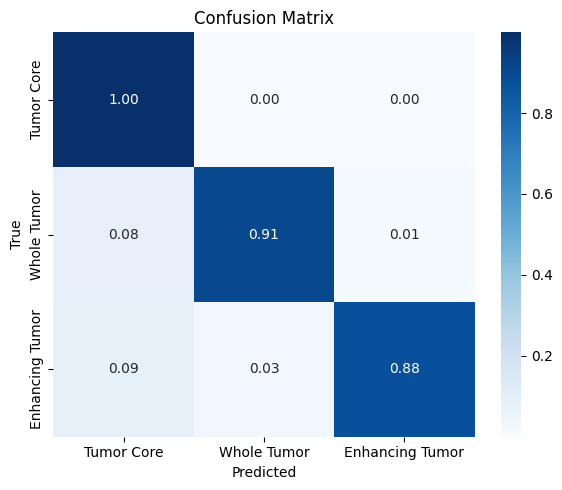

In [ ]:
from sklearn.metrics import confusion_matrix

# ---- Confusion Matrix ----
all_preds_tensor = torch.cat(all_preds, dim=0)
all_targets_tensor = torch.cat(all_targets, dim=0)

cm = compute_confusion_matrix(all_targets_tensor, all_preds_tensor, num_classes=3)
plot_confusion_matrix(cm, class_names = ['Tumor Core', 'Whole Tumor', 'Enhancing Tumor'], normalize=True)


In [ ]:
def compute_iou_dice(cm, class_names):
    iou_scores = []
    dice_scores = []

    print("\nPer-class IoU and Dice Score:")
    for i, name in enumerate(class_names):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        IoU = TP / (TP + FP + FN + 1e-7)
        Dice = 2 * TP / (2 * TP + FP + FN + 1e-7)

        iou_scores.append(IoU)
        dice_scores.append(Dice)

        print(f"{name:18}: IoU = {IoU:.4f} | Dice = {Dice:.4f}")

    # 🔹 Print averages
    avg_iou = np.mean(iou_scores)
    avg_dice = np.mean(dice_scores)
    print(f"\n🔹 Average IoU  = {avg_iou:.4f}")
    print(f"🔹 Average Dice = {avg_dice:.4f}")

    return avg_iou, avg_dice  # Optional: to log per epoch
avg_iou, avg_dice = compute_iou_dice(cm, class_names = ['Tumor Core', 'Whole Tumor', 'Enhancing Tumor'])



Per-class IoU and Dice Score:
Tumor Core        : IoU = 0.9988 | Dice = 0.9994
Whole Tumor       : IoU = 0.8452 | Dice = 0.9161
Enhancing Tumor   : IoU = 0.7581 | Dice = 0.8624

🔹 Average IoU  = 0.8674
🔹 Average Dice = 0.9260


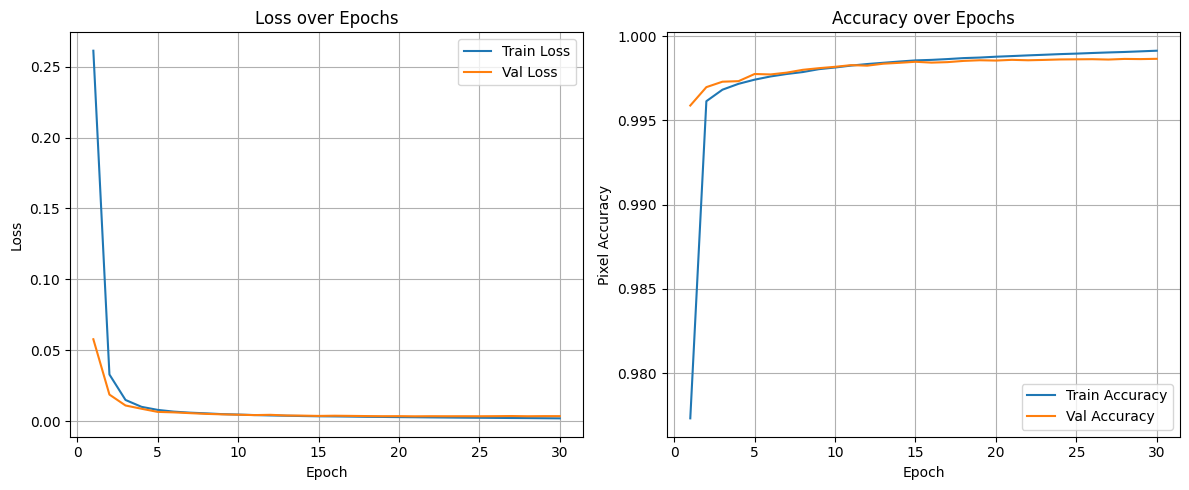

In [ ]:
epochs = range(1, 31)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses,label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# Define RGB colors for your 3 BraTS classes
CLASS_COLORS = {
    0: [0, 0, 0],        # Tumor Core – black
    1: [0, 255, 0],      # Whole Tumor – green
    2: [255, 0, 0],      # Enhancing Tumor – red
}

def decode_segmap(mask):
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in CLASS_COLORS.items():
        rgb[mask == class_idx] = color
    return rgb

def visualize_multiple_samples(model, dataset, indices, device='cuda'):
    model.eval()
    n = len(indices)

    fig, axes = plt.subplots(n, 6, figsize=(14, 3 * n))
    if n == 1:
        axes = axes[np.newaxis, :]  # ensure 2D array if only one sample

    for row, idx in enumerate(indices):
        image, true_mask = dataset[idx]
        image_input = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(image_input)
            pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

        # RGB masks
        true_rgb = decode_segmap(true_mask.cpu().numpy())
        pred_rgb = decode_segmap(pred_mask)

        # List of images: 4 modalities + GT + prediction
        images_to_show = [image[i].cpu().numpy() for i in range(4)] + [true_rgb, pred_rgb]
        titles = ["T1", "T1ce", "T2", "FLAIR", "Ground Truth", "Prediction"]

        for col in range(6):
            ax = axes[row][col]
            img = images_to_show[col]
            if isinstance(img, np.ndarray) and img.ndim == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            ax.set_title(titles[col], fontsize=8)
            ax.axis('off')

    plt.tight_layout()
    plt.show()



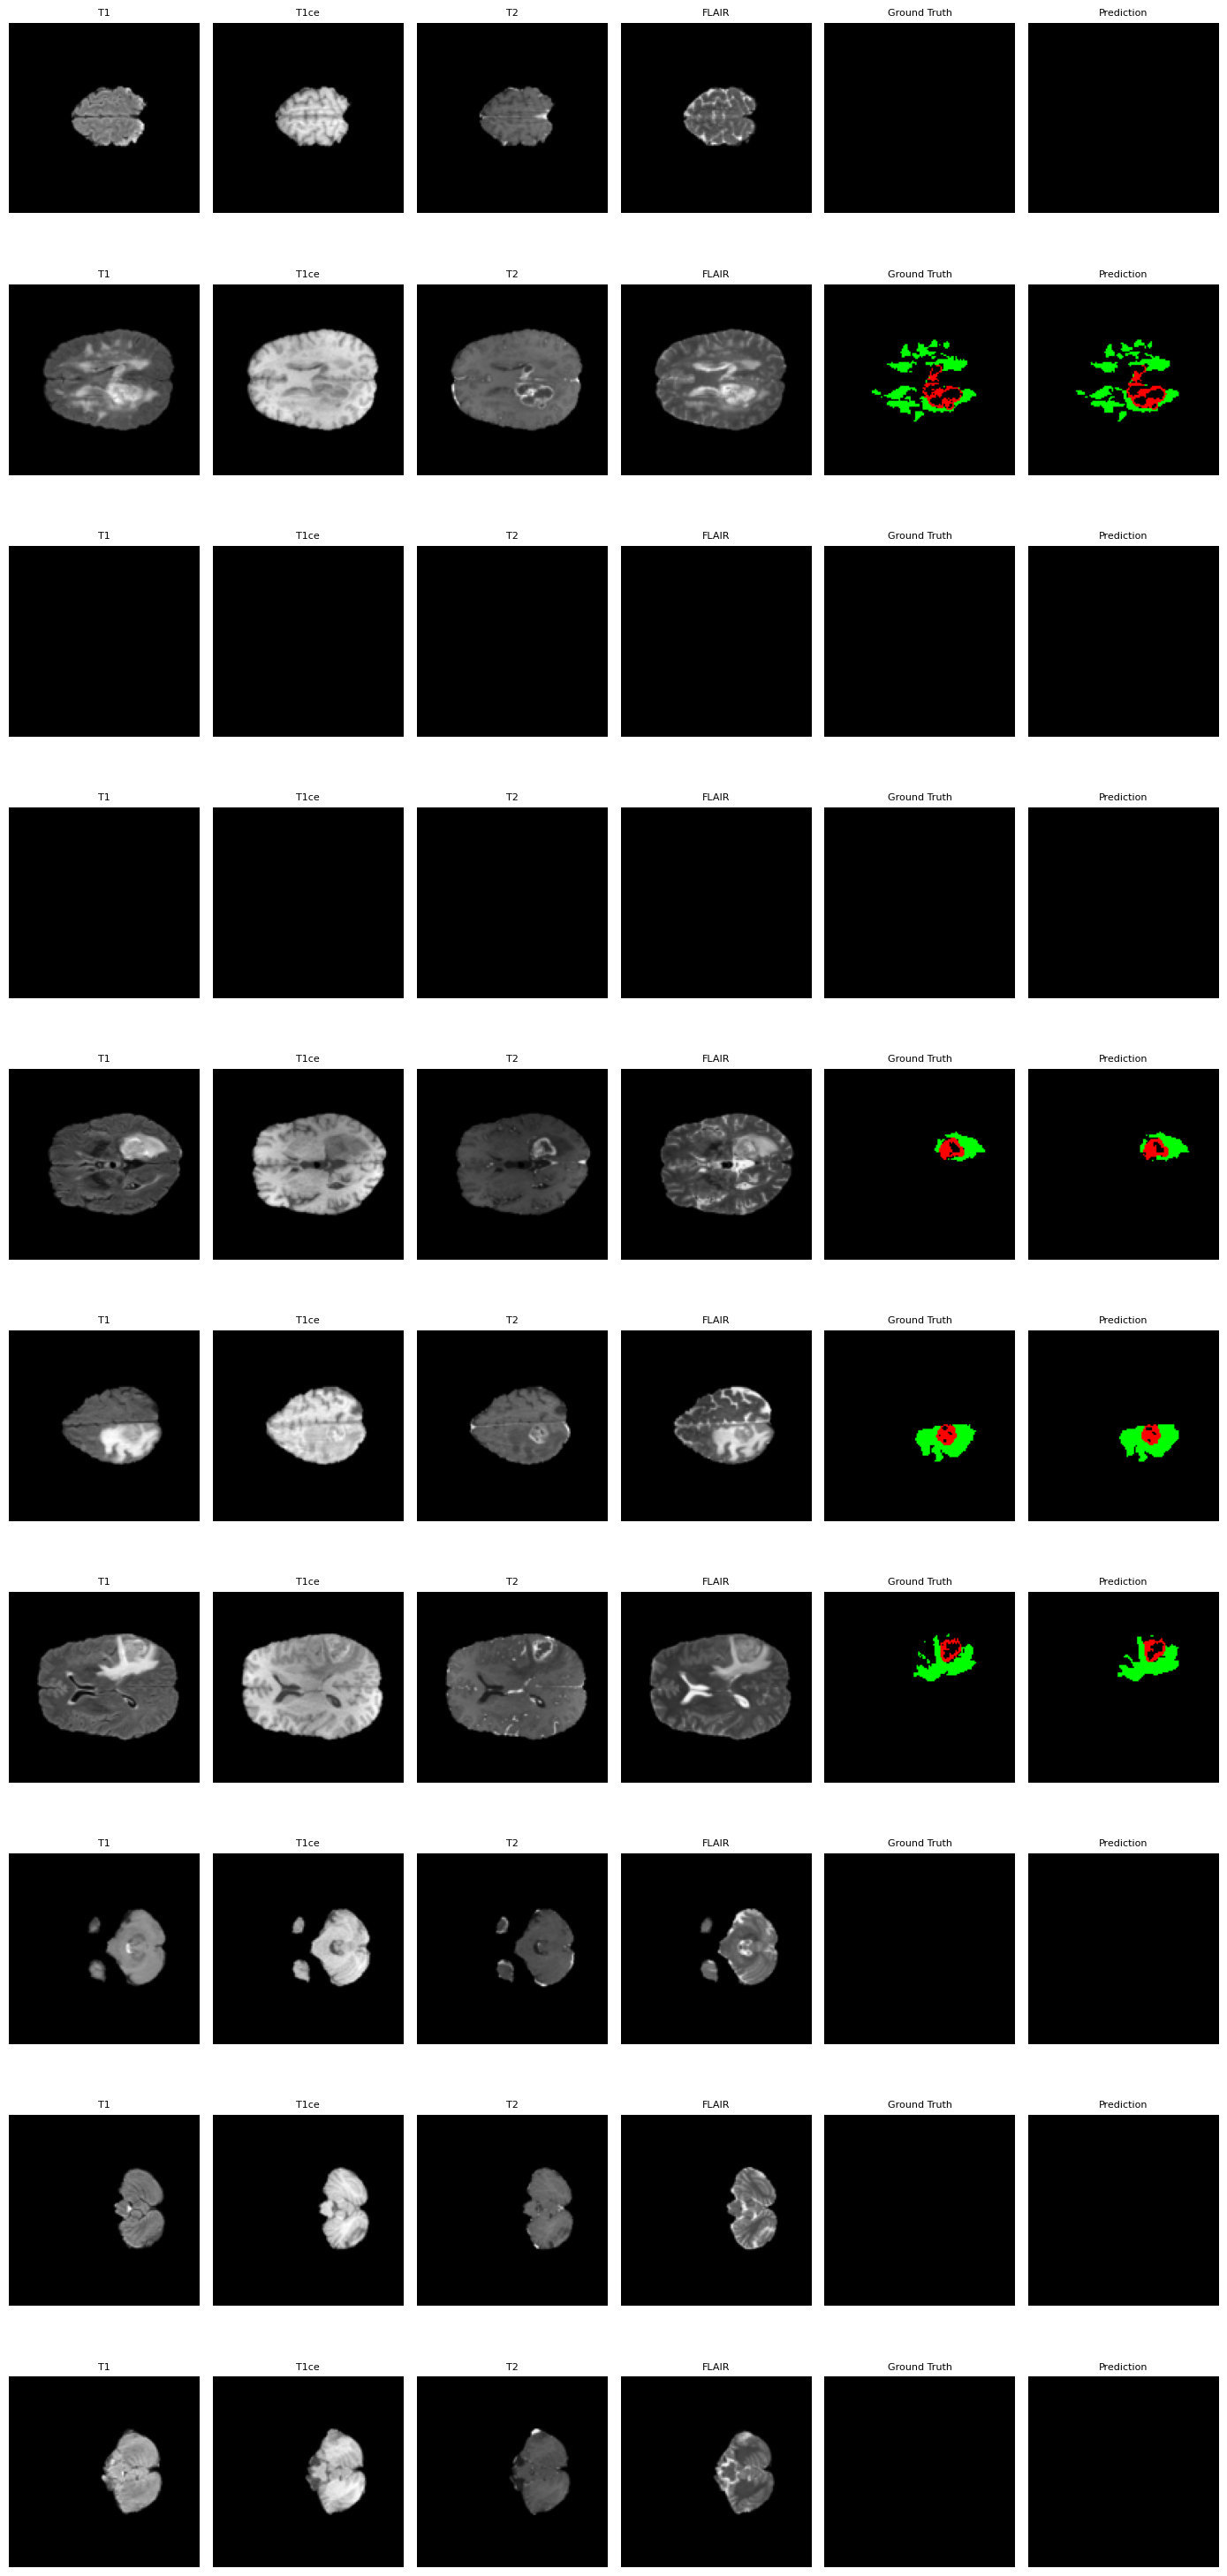

In [ ]:
import random
random_indices = random.sample(range(len(val_dataset)), 10)
visualize_multiple_samples(model, val_dataset, indices=random_indices, device=device)
